<a href="https://colab.research.google.com/github/SylwiaNowakowska/LLM_Fine_Tuning_Molecular_Properties/blob/main/01_ChemBERTa2_HIV_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning of ChemBERTa-2 on HIV Dataset


## Environment setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 838.8/838.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 23.0 MB/s eta 0:00:00


'2.7.2.dev'

In [ ]:
!pip install transformers
!pip install simpletransformers
!pip install wandb
!cd ..

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 27.3 MB/s eta 0:00:00


In [ ]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 1633, done.
remote: Counting objects: 100% (329/329), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 1633 (delta 231), reused 225 (delta 211), pack-reused 1304
Receiving objects: 100% (1633/1633), 198.37 MiB | 16.82 MiB/s, done.
Resolving deltas: 100% (1073/1073), done.


We're going to clone an auxillary repository, bert-loves-chemistry, which will enable us to use the MolNet dataloader for ChemBERTa, which automatically generates scaffold splits on any MoleculeNet dataset!

In [ ]:
!git clone https://github.com/seyonechithrananda/bert-loves-chemistry.git

Cloning into 'bert-loves-chemistry'...
remote: Enumerating objects: 1566, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 1566 (delta 96), reused 91 (delta 91), pack-reused 1364
Receiving objects: 100% (1566/1566), 55.35 MiB | 22.21 MiB/s, done.
Resolving deltas: 100% (1000/1000), done.
Updating files: 100% (122/122), done.


## Imports and parameters setting

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from typing import List

from rdkit import Chem
from transformers import AutoModelForMaskedLM, AutoTokenizer, pipeline, RobertaModel, RobertaTokenizer
from simpletransformers.classification import ClassificationModel, ClassificationArgs

# import MoleculeNet loaders from DeepChem
from deepchem.molnet import load_bbbp, load_clearance, load_clintox, load_delaney, load_hiv, load_qm7, load_tox21

# import MoleculeNet dataloder from bert-loves-chemistry fork
%cd /content/bert-loves-chemistry
from chemberta.utils.molnet_dataloader import load_molnet_dataset, write_molnet_dataset_for_chemprop

/content/bert-loves-chemistry


In [ ]:
# set the logging directories
project_name = "ChemBERTA_HIV"
output_path = '/content/drive/MyDrive/COLAB_NOTEBOOKS/LLM_Fine_Tuning_Molecular_Properties_output'
model_name = 'model_36'

model_folder = os.path.join(output_path, model_name)

evaluation_folder = os.path.join(output_path, model_name + '_evaluation')
if not os.path.exists(evaluation_folder):
    os.makedirs(evaluation_folder)

# set the parameters
EPOCHS = 200
BATCH_SIZE = 256
patience = 15
optimizer = "AdamW"
learning_rate = 0.00001
manual_seed = 112
print(model_folder)

/content/drive/MyDrive/COLAB_NOTEBOOKS/LLM_Fine_Tuning_Molecular_Properties_output/model_36


## Dataset Loading & Splitting

In [ ]:
def plot_classes_distribution(dataframes, class_column, colors, figure_title=None,  plot_titles=None, figsize=(15, 6), equal_y_scale=False, fig_output_path=None):
    """
    Function plotting classes distribution in dataframe(s).

    Args:
        dataframes (list of dataframes): list of dataframes to plot the classes distribution
        class_column (str): column in dataframes identifying the class
        figure title (str): optional
        plot_titles (list of str): optional
        colors (list of str): colors of the bars in each plot
        figsize (tuple of int): figure width and height
        equal_y_scale (bool): whether the plots, should have equal y scale
        fig_output_path (str): optional
    """

    subplots_number = len(dataframes)
    dataframes_value_counts = []


    plt.rcParams.update({'font.size': 16})
    fig, axs = plt.subplots(1,subplots_number, figsize=figsize)

    if figure_title:
        fig.suptitle(figure_title, fontsize=22, y = 1, x = 0.52)

    for i, df in enumerate(dataframes):
        df_value_counts = df[class_column].value_counts().sort_index()

        if len(dataframes) == 1:
            axs.bar(df_value_counts.index, df_value_counts, color=colors[0], alpha=0.7)

            if plot_titles:
                axs.set_title(plot_titles)

        else:
            axs[i].bar(df_value_counts.index, df_value_counts, color=colors[i], alpha=0.7)

            if plot_titles:
                axs[i].set_title(plot_titles[i])

        dataframes_value_counts.append(df_value_counts)

    fig.tight_layout(pad=2.0)

    if equal_y_scale:
        y_min_plots = []
        y_max_plots = []

        for i, ax in enumerate(axs):
            y_min, y_max = axs[i].get_ylim()
            y_min_plots.append(y_min)
            y_max_plots.append(y_max)

        for i, ax in enumerate(axs):
            axs[i].set_ylim(min(y_min_plots), max(y_max_plots))

    if fig_output_path:
        plt.savefig(fig_output_path, dpi=100, pad_inches=1, facecolor="white")

    plt.show()

    return dataframes_value_counts

In [ ]:
# load the dataset, which is is by default split 80/10/10 with a scaffold split
tasks, (train_df, valid_df, test_df), transformers = load_molnet_dataset("hiv", tasks_wanted=None)

[08:06:05] WARNING: not removing hydrogen atom without neighbors
[08:06:05] WARNING: not removing hydrogen atom without neighbors
[08:06:24] WARNING: not removing hydrogen atom without neighbors
[08:06:24] WARNING: not removing hydrogen atom without neighbors


Using tasks ['HIV_active'] from available tasks for hiv: ['HIV_active']


In [ ]:
print(f"The number of molecules in the train set {train_df.shape[0]}")
print(f"The number of molecules in the valid set {valid_df.shape[0]}")
print(f"The number of molecules in the test set {test_df.shape[0]}")
train_df.head()

The number of molecules in the train set 32901
The number of molecules in the valid set 4113
The number of molecules in the test set 4113


,text,labels
0,CCOP(=O)(Nc1cccc(Cl)c1)OCC,0
1,O=C(O)c1ccccc1O,0
2,CCOP(N)(=O)c1ccccc1,0
3,NNP(=S)(NN)c1ccccc1,1
4,Nc1c(Cl)cc(Cl)cc1C(=O)O,0


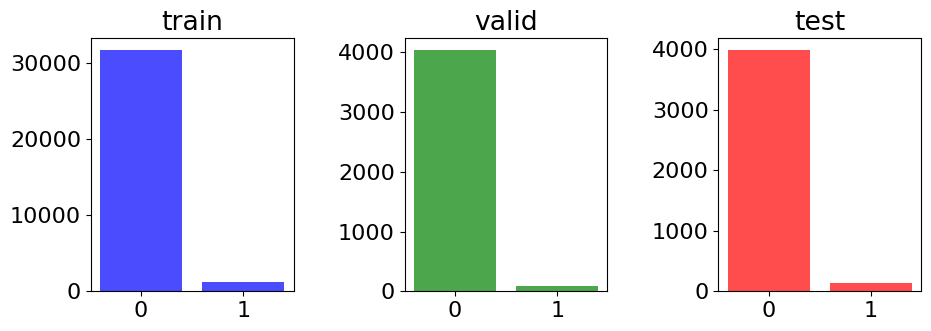

In [ ]:
value_counts = plot_classes_distribution(dataframes=[train_df, valid_df, test_df], class_column='labels', colors=['blue', 'green', 'red'], figure_title=None,  plot_titles=['train', 'valid', 'test'], figsize=(10, 4), equal_y_scale=False, fig_output_path=None)

## Fine-tuning

In [ ]:
import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
# log in to Weights & Biases for experiment tracking
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# configure Weights & Biases logging
wandb_kwargs = {'name' : model_name}

# configure training
classification_args = {'evaluate_each_epoch': True,
                       'evaluate_during_training_verbose': True,
                       'evaluate_during_training' : True,
                       'best_model_dir' : model_folder,
                       'no_save': False,
                       'save_eval_checkpoints': False,
                       'save_model_every_epoch': False,
                       'save_best_model' : True,
                       'save_steps': -1,
                       'num_train_epochs': EPOCHS,
                       'use_early_stopping': True,
                       'early_stopping_patience': patience,
                       'early_stopping_delta': 0.001,
                       'early_stopping_metrics': 'eval_loss',
                       'early_stopping_metrics_minimize': True,
                       'early_stopping_consider_epochs' : True,
                       'fp16' : False,
                       'optimizer' : optimizer,
                       'adam_betas' : (0.95, 0.999),
                       'learning_rate' : learning_rate,
                       'manual_seed': manual_seed,
                       'train_batch_size' : BATCH_SIZE,
                       'eval_batch_size' : BATCH_SIZE,
                       'logging_steps' : len(train_df) / BATCH_SIZE,
                       'auto_weights': True, # change to true
                       'wandb_project': project_name,
                       'wandb_kwargs': wandb_kwargs}

model = ClassificationModel('roberta', 'DeepChem/ChemBERTa-77M-MLM', args=classification_args)

In [ ]:
print(model.tokenizer)

RobertaTokenizerFast(name_or_path='DeepChem/ChemBERTa-77M-MLM', vocab_size=591, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)}, clean_up_tokenization_spaces=True)


In [ ]:
# Train the model
results = model.train_model(train_df, eval_df=valid_df, output_dir=model_folder)

  0%|          | 0/32901 [00:00<?, ?it/s]

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Running Epoch 0 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 1 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 2 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 3 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 4 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 5 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 6 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 7 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 8 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 9 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 10 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 11 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 12 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 13 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 14 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 15 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 16 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 17 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 18 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 19 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 20 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 21 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 22 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 23 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 24 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 25 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 26 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 27 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 28 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 29 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 30 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 31 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 32 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 33 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 34 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 35 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 36 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Epoch 37 of 200:   0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4113 [00:00<?, ?it/s]

## Evaluation

In [ ]:
# load the best model
model = ClassificationModel('roberta', model_folder, args=classification_args)

In [ ]:
# evaluate the best model
result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=sklearn.metrics.accuracy_score)
print(result)

  0%|          | 0/4113 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]

auprc,▁▁▁▁▂▂▂▂▂▃▃▃▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██████████
auroc,▁▂▂▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████████████████████
eval_loss,█▇▆▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fn,▅█████████████▇▆▆▆▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
fp,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
mcc,▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████
tn,▁███████████████████████████████████████
tp,▄▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████
train_loss,█▇▇▅▃▃▂▂▂▁▃▂▂▃▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▁▂▂▂▃▂▁▂▂▂▁
auprc,0.33434


{'mcc': 0.37723524036048023, 'tp': 30, 'tn': 3967, 'fp': 16, 'fn': 100, 'auroc': 0.7931960833542555, 'auprc': 0.3255675238736027, 'acc': 0.9717967420374423, 'eval_loss': 0.10411631622735192}


In [ ]:
# save the results
test_eval_results_path = os.path.join(evaluation_folder, 'test_eval_results.txt')
with open(test_eval_results_path, 'w+', encoding='latin-1') as file:
    file.write(str(result))

In [ ]:
# save the predictions
def make_predictions_df(test_df, model_outputs):
    predictions_df = test_df.copy()
    predictions_df['class_0_probability'] = model_outputs[:, 0]
    predictions_df['class_1_probability'] = model_outputs[:, 1]
    predictions_df['y_pred'] = np.argmax(model_outputs, axis=1)
    return predictions_df

In [ ]:
predictions_df = make_predictions_df(test_df, model_outputs)
predictions_df_path = os.path.join(evaluation_folder, 'predictions_df.csv')
predictions_df.to_csv(predictions_df_path)
predictions_df.head()

,text,labels,class_0_probability,class_1_probability,y_pred
0,CN=C1OC2(c3ccccc3)C3=C(OC(=NC)N2C)C(=O)OC3(c2c...,0,1.991554,-2.474177,0
1,c1ccc2c(c1)[nH]c1c3ccccc3sc21,0,1.659338,-2.097368,0
2,CN1C(=O)N(C)P(=O)(c2ccccc2)P1c1ccccc1,0,1.971669,-2.436386,0
3,O=C(c1ccccc1)N1OCCCc2ccccc21,0,1.928813,-2.344722,0
4,COC(=O)c1c2c(cc3nc4ccccc4nc13)OCO2,0,1.767895,-2.166682,0


In [ ]:
import seaborn as sns
from sklearn.metrics import *

def plot_prediction_distribution(pred_array, fig_output_path=None):

    plt.figure(figsize=(6,4))
    plt.hist(pred_array, bins=50)
    plt.title('Distribution of model predictions')
    plt.xlabel('Probability')
    plt.ylabel('# number of images')
    plt.tight_layout(pad=1.0)
    if fig_output_path:
        plt.savefig(fig_output_path, dpi=100, pad_inches=1, facecolor="white")
    plt.show()
    print(f'Model prediction min: {pred_array.min():.3}')
    print(f'Model prediction max: {pred_array.max():.3}')

def plot_AUROC(GT_array, pred_array, fig_output_path=None):

    plt.figure(figsize=(6,4))
    fpr, tpr, thresholds = roc_curve(GT_array, pred_array)
    plt.plot(fpr, tpr, label = '%s (AUC: %0.4f)'  % ('Model', auc(fpr, tpr)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',label='Random choice')
    plt.legend()
    plt.tight_layout(pad=1.0)
    if fig_output_path:
        plt.savefig(fig_output_path, dpi=100, pad_inches=1, facecolor="white")
    plt.show()


def plot_precision_recall_curve(GT_array, pred_array, fig_output_path=None):

    plt.figure(figsize=(6,4))
    precision, recall, thresholds = precision_recall_curve(GT_array, pred_array)
    plt.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Model', average_precision_score(GT_array,pred_array)))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.tight_layout(pad=1.0)
    if fig_output_path:
        plt.savefig(fig_output_path, dpi=100, pad_inches=1, facecolor="white")
    plt.show()


def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)


def plot_f1_tresh(GT_array, pred_array, fig_output_path=None):
    precision, recall, thresholds = precision_recall_curve(GT_array, pred_array)
    f1 = calc_f1(precision, recall)
    plt.figure(figsize=(6,4))
    plt.plot(f1[:-1], thresholds)
    plt.xlabel('F1 score')
    plt.ylabel('Treshold')
    plt.tight_layout(pad=1.0)
    if fig_output_path:
        plt.savefig(fig_output_path, dpi=100, pad_inches=1, facecolor="white")
    plt.show()


def plot_confusion_matrix(cf_matrix, classes, title=None, percentage=True, font_size=16, figsize=(8,8), fig_output_path=None):
    fig, axs = plt.subplots(1, 1, figsize=figsize)
    plt.rcParams.update({'font.size': 16})

    if title:
        fig.suptitle(title, fontsize=22, y = 1, x = 0.52)

    if percentage == True:
        sns.heatmap(cf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt=".0%", cbar=False, square=True, ax=axs, cmap="Blues")
    else:
        sns.heatmap(cf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d", cbar=False, square=True, ax=axs, cmap="Blues")
    axs.set_xlabel("Predicted labels", fontsize=20)
    axs.set_ylabel("True labels",fontsize=20)
    fig.tight_layout(pad=1.0)

    if fig_output_path:
        plt.savefig(fig_output_path, dpi=100, pad_inches=1, facecolor="white")

    plt.show()


def evaluate(GT_array, pred_array, output_folder_path=None):
    if output_folder_path:
        prediction_distribution_output = os.path.join(output_folder_path, 'prediction_distribution.tiff')
        AUROC_output = os.path.join(output_folder_path, 'AUROC.tiff')
        precision_recall_output = os.path.join(output_folder_path, 'precision_recall.tiff')
        t1_tresh_output = os.path.join(output_folder_path, 't1_tresh.tiff')

    else:
        prediction_distribution_output = None
        AUROC_output = None
        precision_recall_output = None
        t1_tresh_output= None

    plot_prediction_distribution(pred_array, fig_output_path=prediction_distribution_output)
    plot_AUROC(GT_array, pred_array, fig_output_path=AUROC_output)
    plot_precision_recall_curve(GT_array, pred_array, fig_output_path=precision_recall_output)
    plot_f1_tresh(GT_array, pred_array, fig_output_path=t1_tresh_output)

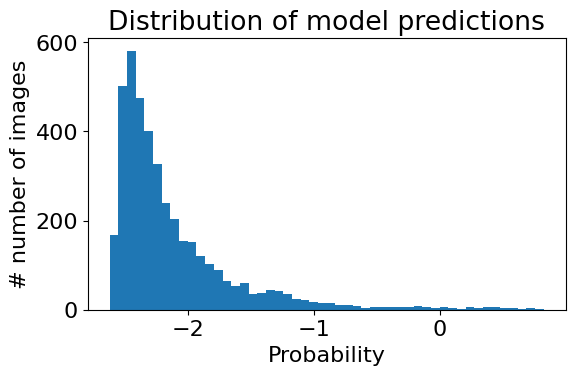

Model prediction min: -2.62
Model prediction max: 0.824


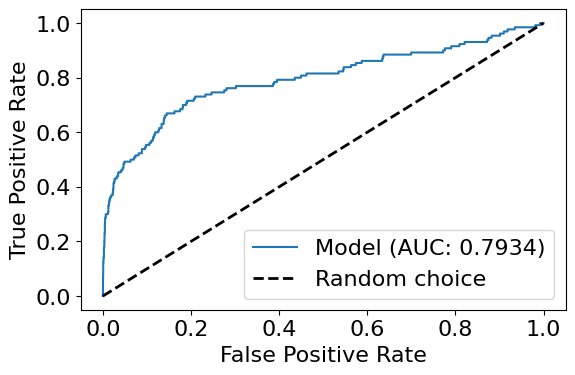

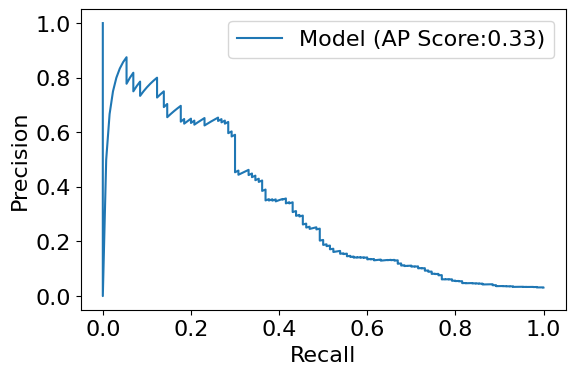

<ipython-input-52-56f987863585>:48: RuntimeWarning: invalid value encountered in divide
  return 2*(prec*recall)/(prec+recall)


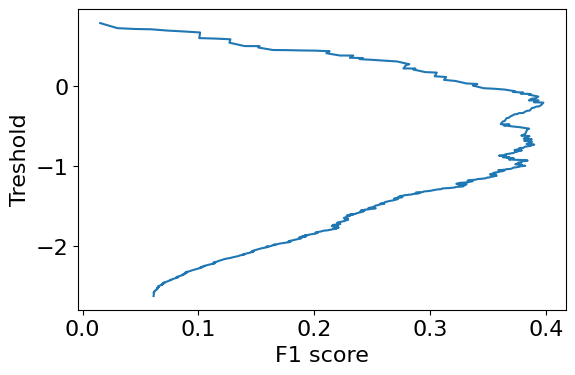

In [ ]:
evaluate(predictions_df['labels'], predictions_df['class_1_probability'], output_folder_path=evaluation_folder)

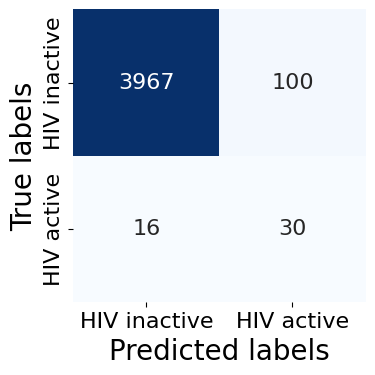

In [ ]:
confusion_matrix = np.array([[result['tn'], result['fn']], [result['fp'], result['tp']]])
plot_confusion_matrix(confusion_matrix, classes=["HIV inactive", "HIV active"], title=None, percentage=False, font_size=16, figsize=(4,4), fig_output_path=None)

## Predicting

In [ ]:
# prediction for molecule from test set with label [0]
predictions, raw_outputs = model.predict(['c1ccc2c(c1)[nH]c1c3ccccc3sc21'])
print(predictions, raw_outputs)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[0] [[ 1.73925781 -1.99414062]]
